In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras
tfk = tfp.math.psd_kernels
import helpers
from scipy.integrate import solve_ivp
import copy, os

import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

# Data Generation + Encoding TFP-Compatible ODE Function `f_vec`

In [2]:
# set a seed for stochasticity
np.random.seed(858)

# model governing the Lorenz system IN A FORMAT SUITABLE FOR TENSORFLOW VECTORIZATION!
def lorenz(t, x, thetas):
    '''
    1. x - array containing (X, Y, Z) components. Suppose it is a tuple.
    2. theta - array containing (beta, rho, sigma) components.
    '''
    return np.hstack([thetas[2] * (x[1] - x[0]), # dx/dt = sigma * (y-x)
                      x[0] * (thetas[1] - x[2]) - x[1], # dy/dt = x * (rho - z) - y
                      x[0]*x[1] - thetas[0]*x[2], # dz/dt = x*y - beta*z
                     ])

# model governing the Lorenz system IN A FORMAT SUITABLE FOR TENSORFLOW VECTORIZATION!
def f_vec(t, X, thetas):
    '''
    1. X - array containing (X, Y, Z) components. Suppose it is (N x D) for vectorization.
    2. theta - array containing (beta, rho, sigma) components.
    '''
    return tf.concat([thetas[2] * (X[:,1:2] - X[:,0:1]), # dx/dt = sigma * (y-x)
                      X[:,0:1] * (thetas[1] - X[:,2:3]) - X[:,1:2], # dy/dt = x * (rho - z) - y
                      X[:,0:1]*X[:,1:2] - thetas[0]*X[:,2:3], # dz/dt = x*y - beta*z
                     ], axis=1)

# create our training data
t_start, t_end = 0.0, 2.5
thetas_true = np.array([8/3, 28.0, 10.0])
ts = np.linspace(start=t_start, stop=t_end, num=10001)
sol = solve_ivp(fun=lorenz, t_span=(ts[0], ts[-1]), 
                y0=np.array([2.0, 2.0, 2.0]), t_eval=ts, 
                rtol=1e-10, atol=1e-10, args=(thetas_true,))
x_true = sol.y.T

# noise up to get our observations + sparsify to simulate real-world conditions
d_obs = 10
n_obs = int((t_end - t_start) * d_obs)
alpha = 0.1
sigmas = alpha * (x_true.max(axis=0) - x_true.min(axis=0))
x_obs = x_true + np.random.normal(loc=0.0, scale=sigmas, size=x_true.shape)
ts_obs, x_obs = ts[::int((ts.shape[0] - 1) / n_obs)], x_obs[::int((ts.shape[0] - 1) / n_obs)]

# cast everything to be float64
ts_obs, x_obs = ts_obs.astype(np.float64), x_obs.astype(np.float64)

# have to tell us how many parameters there are!
d_thetas = 3

'''
# FOR TESTING PURPOSES ONLY - PRETEND THAT SOME COMPONENTS ARE (PARTIALLY/COMPLETELY) UNOBSERVED
obs_mask = np.random.binomial(n=1, p=0.5, size=x_obs.shape).astype(bool)
x_obs[obs_mask] = np.nan; # x_obs[:,1:] = np.nan
'''

print("Finished generating data.")

Finished generating data.


# Setting Discretization and Fitting $(\phi, \sigma^2)$ for Observed Components

In [3]:
# right now, assuming that true noise levels are NOT specified!
verbose = True

# record dimensionalities
N, D, discret = x_obs.shape[0], x_obs.shape[1], 3

# let's also observe how many not-NaN entries do we have in our data x_obs?
N_ds = (~tf.math.is_nan(x_obs).numpy()).sum(axis=0)

# discretize ts_obs to get our set of constrained timesteps (2^discret - 1 np.nan's between subsequent obs.)
N_discret = (2 ** discret) * (N-1) + 1
I = np.full(shape=(N_discret,), fill_value=np.nan) 
X_obs_discret = np.full(shape=(N_discret, D), fill_value=np.nan)

# put in evenly-spaced timesteps for I
I[::(2 ** discret)] = ts_obs
indices = np.arange(len(I))
I = np.interp(x=indices, xp=indices[~np.isnan(I)], fp=I[~np.isnan(I)])
I = I.reshape(-1, 1) # force into column for TFP compatibility

# store the size of I, it'll be useful later
mag_I = I.shape[0]

# pg. 7-8 of PNAS paper: to better temper the prior vs. the likelihood
beta = (D * mag_I) / N_ds.sum()

# fill with our observed values
X_obs_discret[::(2 ** discret)] = x_obs

# pre-save BEFORE WE INTERPOLATE, what y(\tau_d) is based on this mask, on the I timescale
y_tau_ds = copy.deepcopy(X_obs_discret)

# flattened indices of where y_tau_ds is NOT NAN, also what columns they correspond to
not_nan_idxs = tf.convert_to_tensor(np.where(~np.isnan(y_tau_ds).flatten())[0])
not_nan_cols = not_nan_idxs % D

# get flattened entries of not-NaN values in y_tau_ds
y_tau_ds_observed = tf.gather(tf.reshape(y_tau_ds, [-1]), not_nan_idxs)

# check which components are observed
observed_indicators = (~np.isnan(X_obs_discret)).mean(axis=0) > 0
observed_components = np.arange(D)[observed_indicators]

# how many observed components do we have?
D_observed = len(observed_components)

# begin by fitting (phi1, phi2, sigma_sq) for our observed components
observed_hparams = helpers.fit_hparams(I=I, X_obs_discret=X_obs_discret, verbose=True, observed=True)

Fitting hparams for 3 observed components:   0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
I0000 00:00:1724633952.278927 1571584 service.cc:146] XLA service 0x600000dc4c00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724633952.278948 1571584 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-08-25 17:59:12.579640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724633954.376248 1571584 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Initializing $\theta$, $(\phi, \sigma^2, X_{\mathbf{I}})$ for Unobserved Components, Build Matrices

In [4]:
# specify our bandsize
BANDSIZE = 20

# if all components are observed, we can a) internalize hparams, b) construct matrices, c) initialize theta.
if np.all(observed_indicators):
    
    # internalize our hyperparameters
    phi1s = observed_hparams["phi1s_observed"].copy()
    phi2s = observed_hparams["phi2s_observed"].copy()
    sigma_sqs_init = observed_hparams["sigma_sqs_observed"].copy()
    Xhat_init = observed_hparams["X_interp"].copy()
    
    # get our prior means mu_ds for each component
    mu_ds = Xhat_init.mean(axis=0)
    
    # create 3 |I| x |I| x D tensor-arrays
    C_d_invs = np.zeros(shape=(D, mag_I, mag_I))
    m_ds = np.zeros(shape=(D, mag_I, mag_I))
    K_d_invs = np.zeros(shape=(D, mag_I, mag_I))

    # build up our pre-computed matrices for each dimension d
    for d in range(D):

        # Eqn. 6 of PNAS paper
        C_d, m_d, K_d = helpers.build_matrices(I, phi1s[d], phi2s[d], v=2.01)
        C_d_invs[d] = tf.linalg.pinv(C_d) # pinv equal to inv if invertible!
        m_ds[d] = m_d
        K_d_invs[d] = tf.linalg.pinv(K_d)
    
    '''
    8/20: XLA compilation + autograph does NOT support sparse tensors. Keep as dense, but banded.
    '''
    # precompute the banded matrix operations
    C_d_invs_banded = tf.linalg.band_part(input=C_d_invs, num_lower=BANDSIZE, num_upper=BANDSIZE)
    K_d_invs_banded = tf.linalg.band_part(input=K_d_invs, num_lower=BANDSIZE, num_upper=BANDSIZE)
    m_ds_banded = tf.linalg.band_part(input=m_ds, num_lower=BANDSIZE, num_upper=BANDSIZE)
    
    # initialize starting theta based on optimizing routine - ASK PROF. YANG IS ONES A GOOD INIT IDEA?!!!
    thetas_var = tf.Variable(initial_value=np.ones(shape=(d_thetas,)), name="thetas_var", dtype=np.float64)

    # loss function - log posterior as a function of ONLY THETAS! (want to MINIMIZE!)
    def theta_objective(thetas):
        '''
        See unnormalized_log_prob for the full posterior + input variables.
        - We can ignore the terms that don't involve theta! (i.e. first, third, and fourth terms)
        - We just need to deal with the 2nd term, which is the only place where theta appears!
        '''
        # pre-compute our centered differences + reshape as needed
        X_cent = tf.reshape(Xhat_init - mu_ds, shape=(Xhat_init.shape[0], 1, Xhat_init.shape[1]))

        # second term: ||f_{d, I} - \mudot_d(I) - m_d{ x_d(I) - \mu_d(I) }||_{K_d^-1}^2
        f_vals = tf.reshape(f_vec(I, Xhat_init, thetas), shape=(Xhat_init.shape[1], Xhat_init.shape[0], 1))
        toNorm = f_vals - (m_ds_banded @ tf.transpose(X_cent, perm=[2, 0, 1]))
        return tf.reduce_sum( tf.transpose(toNorm, perm=[0, 2, 1]) @ (K_d_invs_banded @ toNorm) )

    # setup our optimizer + our one-step Adam function
    num_iters = 10000; optimizer = tf_keras.optimizers.Adam(learning_rate=.01)
    @tf.function(autograph=True, jit_compile=True)
    def fit_theta_step():
      with tf.GradientTape() as tape:
        loss = theta_objective(thetas_var)
      grads = tape.gradient(loss, thetas_var)
      optimizer.apply_gradients([(grads, thetas_var)])
      return loss

    # run our parameter initialization for theta!
    if verbose:
        for i in tqdm(range(num_iters), desc="Initializing theta"):
          loss = fit_theta_step()
    else:
        for i in range(num_iters):
            loss = fit_theta_step()
            
    # extract out our thetas_init, which should make us ready for sampling!
    thetas_init = thetas_var.numpy().copy()
    
else:
    '''
    If we're missing components, we cannot use Adam+Autograd to fit the missing components!
    - Autograd cannot differentiate thru the Bessel-function-based matrix constructions.
    - Ask Prof. Yang, must we use nu=2.01? If we use something else, we can autograd everything!
    - Create a wrapper objective function that ONLY TAKES AS INPUT thetas + (phi1, phi2, X_I)
    for the missing components and then blasts our big full posterior function.
    - Note that sigma_sq is NOT IDENTIFIABLE FOR MISSING COMPONENTS!
    - maybe can try gradient-matching for initializing the missing component? Ask Prof. Yang!
    - ODEINT PERMISSIONS? MAYBE JUST L2 MATCH ON X_unobs, then interpolate + GP fit & use full routine?
    - Phi2 seems to get driven to zero, which is a problem.
    '''
    # begin by internalizing our fitted hyperparameters for the OBSERVED COMPONENTS, else NaN.
    phi1s = np.full(shape=(D,), fill_value=np.nan)
    phi1s[observed_components] = observed_hparams["phi1s_observed"].copy()
    phi2s = np.full(shape=(D,), fill_value=np.nan)
    phi2s[observed_components] = observed_hparams["phi2s_observed"].copy()
    sigma_sqs_init = np.full(shape=(D,), fill_value=np.nan)
    sigma_sqs_init[observed_components] = observed_hparams["sigma_sqs_observed"].copy()
    Xhat_init = observed_hparams["X_interp"].copy()
    
    # create 3 |I| x |I| x D tensor-arrays
    C_d_invs = np.zeros(shape=(D, mag_I, mag_I))
    m_ds = np.zeros(shape=(D, mag_I, mag_I))
    K_d_invs = np.zeros(shape=(D, mag_I, mag_I))
    
    # fill in these matrices for observed components and then take band matrix approxes
    for d in observed_components:

        # Eqn. 6 of PNAS paper
        C_d, m_d, K_d = helpers.build_matrices(I, phi1s[d], phi2s[d], v=2.01)
        C_d_invs[d] = tf.linalg.pinv(C_d) # pinv equal to inv if invertible!
        m_ds[d] = m_d
        K_d_invs[d] = tf.linalg.pinv(K_d)
    
    # which components are NOT observed?
    unobserved_components = np.setdiff1d(np.arange(D), observed_components)
    D_unobserved = len(unobserved_components)
    
    '''
    Skyler's missing component hparam setting approach:
    1. Optimize X_unobs and theta purely based on matching ODE derivatives via f_vec to finite differences.
    2. Fit (phi1, phi2, sigma_sq) based on X_unobs using direct call to helpers.fit_observed_hparams.
    
    *ADVANTAGES: 
    a. Don't need to deal with (phi1, phi2) together with X_unobs & theta jointly.
    b. sigma_sq is now identifiable!
    
    *FUTURE IDEAS:
    1. can take derivative difference loss only at observed components / observed timesteps (seems bad).
    2. Note that initial estimates of unobserved trajectories are very stable. General shapes match too.
    3. BUT, it does seem to be translated up / down.
    '''
    # convert to tensor for tensorflow compatibility. Will need to gather + reorder columns
    Xhat_init_tf = tf.convert_to_tensor(Xhat_init)
    proper_order = np.argsort(np.concatenate([observed_components, unobserved_components]))
    
    # loss function for finite differences
    def unobserved_objective(X_unobs, thetas):
        
        # create our full implied observations by filling with X_unobs
        X_full = tf.gather(tf.concat([tf.gather(Xhat_init_tf, indices=observed_components, axis=1), 
                                      X_unobs], axis=1), indices=proper_order, axis=1)
        
        # compute implied derivatives on all components.
        f_vals = f_vec(I, X_full, thetas)

        '''
        Compute 2nd-order finite-diff approx:
        - f'(x) ~ (f(x+dx) - f(x-dx)) / (2dx) (assuming equally spaced I!)
        '''
        # can assume fixed dx stepsize looking at I
        f_diff = (X_full[2:,:] - X_full[:-2,:]) / (2*(I[1,0] - I[0,0]))

        # return L2 error of f_vals and f_diff
        return tf.reduce_sum((f_vals[1:-1] - f_diff) ** 2)
        
    # initialize our guesses + setup as autograd variables
    mu_unobs_init = np.nanmean(Xhat_init.mean(axis=0))
    sd_unobs_init = np.nanmean(Xhat_init.std(axis=0) ** 2) ** 0.5
    X_unobs_var = tf.Variable(initial_value=np.random.normal(loc=mu_unobs_init, 
                                                             scale=sd_unobs_init, 
                                                             size=(mag_I, D_unobserved)), 
                              name="X_unobs_var", dtype=np.float64)
    thetas_var = tf.Variable(initial_value=np.ones((d_thetas,)), name="thetas_var", dtype=np.float64)
    
    # setup our optimizer + our one-step Adam function + run
    num_iters = 10000; optimizer = tf_keras.optimizers.Adam(learning_rate=.01)
    @tf.function(autograph=True, jit_compile=True)
    def fit_unobserved_step():
      with tf.GradientTape() as tape:
        loss = unobserved_objective(X_unobs_var, thetas_var)
      grads = tape.gradient(loss, [X_unobs_var, thetas_var])
      optimizer.apply_gradients(zip(grads, [X_unobs_var, thetas_var]))
      return loss
    if verbose:
        for i in tqdm(range(num_iters), desc="Fitting X_unobs and theta"):
          loss = fit_unobserved_step()
    else:
        for i in range(num_iters):
            loss = fit_unobserved_step()
            
    # extract out our theta + our init for X_unobs
    thetas_init = thetas_var.numpy().copy()
    Xhat_init_unobs = X_unobs_var.numpy().copy()
            
    # fit (phi1, phi2, sigma_sq) for unobserved components.
    unobserved_hparams = helpers.fit_hparams(I=I, X_obs_discret=Xhat_init_unobs, verbose=True, observed=False)
    
    # update our full phi1, phi2, sigma_sq_inits, Xhat_init
    phi1s[unobserved_components] = unobserved_hparams["phi1s_observed"]
    phi2s[unobserved_components] = unobserved_hparams["phi2s_observed"]
    sigma_sqs_init[unobserved_components] = unobserved_hparams["sigma_sqs_observed"]
    Xhat_init[:,unobserved_components] = unobserved_hparams["X_interp"]
    
    # get our prior means mu_ds for each component
    mu_ds = Xhat_init.mean(axis=0)
    
    # also update our matrices: C_d_invs_banded, K_d_invs_banded, m_ds_banded
    for d in unobserved_components:
        
        # Eqn. 6 of PNAS paper
        C_d, m_d, K_d = helpers.build_matrices(I, phi1s[d], phi2s[d], v=2.01)
        C_d_invs[d] = tf.linalg.pinv(C_d) # pinv equal to inv if invertible!
        m_ds[d] = m_d
        K_d_invs[d] = tf.linalg.pinv(K_d)
        
    # precompute the banded matrix operations before sampling!
    C_d_invs_banded = tf.linalg.band_part(input=C_d_invs, num_lower=BANDSIZE, num_upper=BANDSIZE)
    K_d_invs_banded = tf.linalg.band_part(input=K_d_invs, num_lower=BANDSIZE, num_upper=BANDSIZE)
    m_ds_banded = tf.linalg.band_part(input=m_ds, num_lower=BANDSIZE, num_upper=BANDSIZE)

Initializing theta:   0%|          | 0/10000 [00:00<?, ?it/s]

# XLA-Compatible Log-Posterior Function + Adaptive NUTS Sampler

In [5]:
# the FULL posterior distribution that we are sampling from (optimized for XLA, yay!)
def unnormalized_log_prob(X, sigma_sqs, thetas):
    '''
    Takes in as input the following, and returns the unnormalized log-posterior
    1. Our samples of the trajectory components X with dimensions |I| x D
    2. sigma_sqs - a (|D|, ) vector of the noises on each component d.
    3. thetas - the (d_thetas,) vector-type sample of the parameters governing our system
    '''
    # pre-compute our centered differences + reshape as needed
    X_cent = tf.reshape(X - mu_ds, shape=(X.shape[0], 1, X.shape[1]))

    # first term: ||x_D(I) - \mu_d(I)||_{C_d^-1}^2
    t1 = tf.reduce_sum( (tf.transpose(X_cent) @ C_d_invs_banded) @ tf.transpose(X_cent, perm=[2, 0, 1]) )

    # second term: ||f_{d, I} - \mudot_d(I) - m_d{ x_d(I) - \mu_d(I) }||_{K_d^-1}^2
    f_vals = tf.transpose(f_vec(I, X, thetas)[:,None], perm=[2, 0, 1])
    toNorm = f_vals - (m_ds_banded @ tf.transpose(X_cent, perm=[2, 0, 1]))
    t2 = tf.reduce_sum( tf.transpose(toNorm, perm=[0, 2, 1]) @ (K_d_invs_banded @ toNorm) )
    
    '''
    print(f_vals)
    print(toNorm)
    print(tf.transpose(toNorm, perm=[0, 2, 1]) @ (K_d_invs_banded @ toNorm))
    print(t2)
    '''

    # third term: N_d log(2\pi \sigma_d^2)
    t3 = tf.reduce_sum(N_ds * tf.math.log(2.0*np.pi * sigma_sqs))

    '''
    Old version of t4: 
    t4 = tf.reduce_sum(tf.math.multiply(
    tf.math.multiply_no_nan(tf.square(X - y_tau_ds), tau_ds_mask), 
    (1.0 / sigma_sqs)))
    '''
    
    # fourth term on ONLY THE ACTUAL OBSERVED VALUES!: ||x_d(\tau_d) - y_d(\tau_d)||_{\sigma_d^{-2}}^2
    X_observed = tf.gather(tf.reshape(X, [-1]), not_nan_idxs)
    t4 = tf.reduce_sum(tf.math.multiply(tf.square(X_observed - y_tau_ds_observed), 
                                        tf.gather(1.0/sigma_sqs, not_nan_cols)))

    # temper using 1/beta: -0.5 * ( ((1/beta) * (t1 + t2)) + (t3 + t4) )
    return -0.5 * ( ((1/beta) * (t1 + t2)) + (t3 + t4) )

In [6]:
# how many samples + burn-in steps are we doing?
num_results, num_burnin_steps = 2000, 2000

'''
Yang et al. randomly selects leapfrog stepsize ~ Unif(L, 2L) for each iteration.
- During burn-in, multiply L by 1.005 if acceptance rate in prev. 100 iterations > 90%.
- During burn-in, multiply L by 0.995 if acceptance rate in prev. 100 iterations < 60%.
'''
# create our NUTS sampler with dual step-size adaptation
nuts_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=unnormalized_log_prob, step_size=0.1)
adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=nuts_kernel, 
                                                            num_adaptation_steps=int(0.8 * num_burnin_steps),
                                                            target_accept_prob=0.75)

# set up our initial state, i.e., our current state
initial_state = [Xhat_init, sigma_sqs_init, thetas_init]

# accelerated sampling.
@tf.function(autograph=True, jit_compile=True)
def run_nuts():
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_sampler,
        trace_fn=lambda _, pkr: pkr
    )
    return samples, kernel_results

# run our samples
start = time.time()
samples, kernel_results = run_nuts()
end = time.time()

# how much time did it take?
minutes = np.round((end - start) / 60, 2)
print(f"Finished sampling in {minutes} minutes.")

2024-08-25 18:01:02.571807: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Finished sampling in 7.25 minutes.


# Checking Results

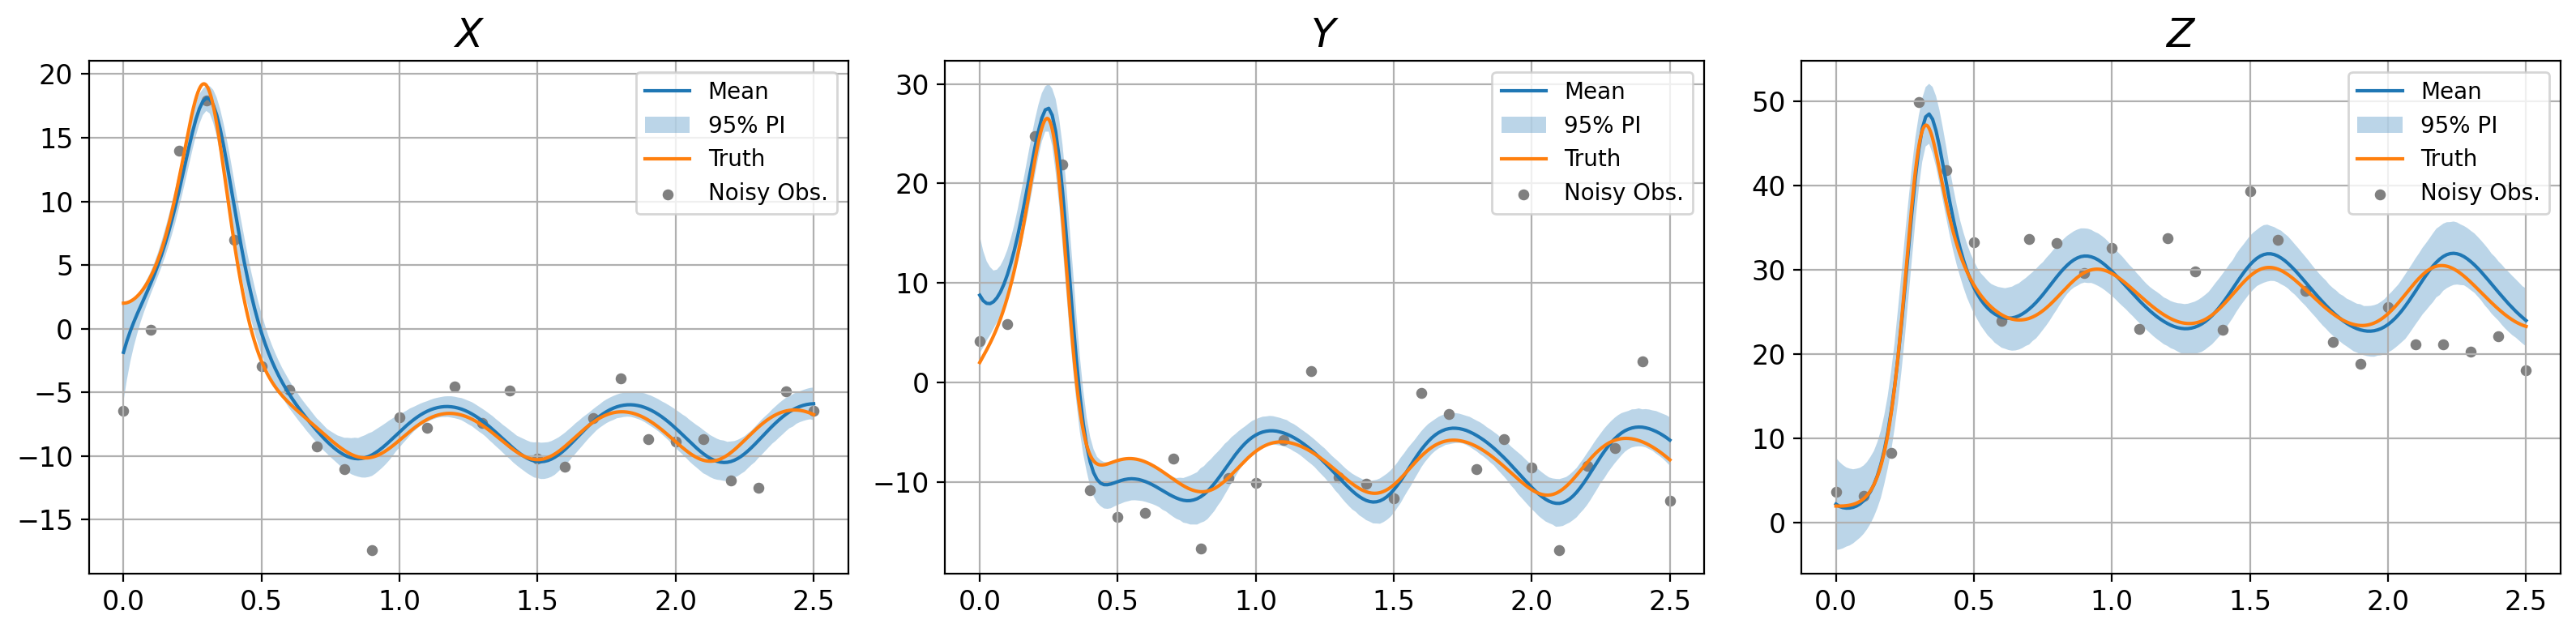

In [7]:
# thetas & sigmas
thetahat = samples[2].numpy().mean(axis=0)
sigmahat = (samples[1].numpy() ** 0.5).mean(axis=0)
Xhat = samples[0].numpy().mean(axis=0)
Xhat_min, Xhat_max = tuple(np.quantile(a=samples[0].numpy(), q=[0.025, 0.975], axis=0))

# plot our trajectories - get flattened timesteps + grid of subplots
ts_discret = I.flatten()
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(16, 4))
for d in range(D):

    # Z component
    ax[d].plot(ts_discret, Xhat[:,d], label="Mean")
    ax[d].fill_between(ts_discret, Xhat_min[:,d], Xhat_max[:,d], alpha=0.3, label="95% PI")
    ax[d].plot(ts, x_true[:,d], label="Truth")
    ax[d].scatter(ts_discret, X_obs_discret[:,d], s=15, color="grey", label="Noisy Obs.")
    ax[d].grid()
    ax[d].set_title(["$X$", "$Y$", "$Z$"][d], fontsize=18)
    ax[d].tick_params("both", labelsize=12)
    ax[d].legend()

# beautify
plt.tight_layout()
plt.show()

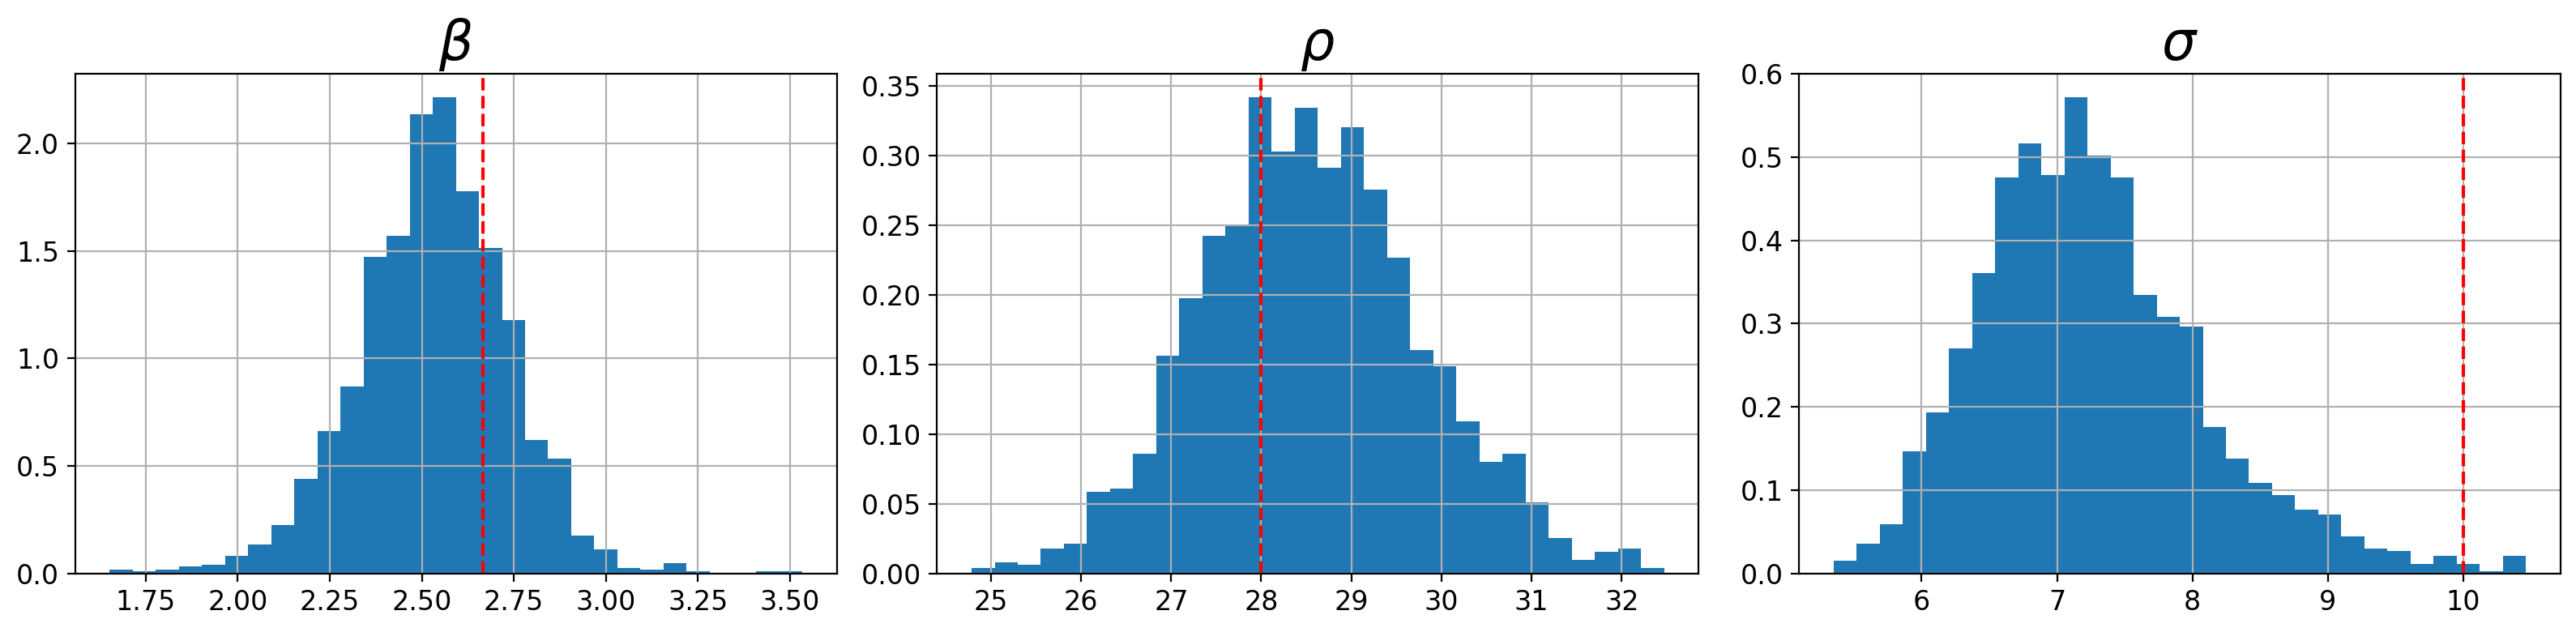

In [8]:
# hot-key letters
b, r, s = "b", "r", "s"

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(16, 4))
for i, var in enumerate([f"$\{b}eta$", f"$\{r}ho$", f"$\{s}igma$"]):

    # histogram of theta samples by component
    ax[i].hist(samples[2].numpy()[:,i], density=True, bins=30)
    ax[i].axvline(x=thetas_true[i], color="red", linestyle="--")
    ax[i].grid()
    ax[i].set_title(var, fontsize=24)
    ax[i].tick_params("both", labelsize=12)

# beautify
plt.tight_layout()
plt.show()